# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil



### Sample Size Calculation

In [3]:
# Calculate effect size based on our expected rates
effect_size= sms.proportion_effectsize(0.13,.15)
required_n= sms.NormalIndPower().solve_power(
    effect_size,
    power=.8,
    alpha=.5,
    ratio=.1)                                    

In [4]:
# Calculate sample size needed
required_n= ceil(required_n)
print(required_n)

7038


### Collecting and preparing the data

In [5]:
# Load the tiktok_data.csv into a dataframe
df=pd.read_csv('tiktok_data.csv')
df.head()

,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [6]:
# Get the info of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [8]:
# Make sure all the control group are seeing the star button and viceversa
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [9]:
# Check that no users have been sampled multiple times 
session_counts=df['user_id'].value_counts(ascending=False)
multi_users= session_counts[session_counts>1].count()
print(multi_users)


3453


In [10]:
# If there are users who have been sampled multiple times, remove them from the dataframe
users_to_drop= session_counts[session_counts>1].index
df=df[~df['user_id'].isin(users_to_drop)]
print(df.shape[0])


268875


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [13]:
# Perform simple random sampling to split the data into control and treatment
control_sample= df[df['group']=='control'].sample(n=required_n, random_state=22)
treatment_sample= df[df['group']=='treatment'].sample(n=required_n, random_state=22)



In [14]:
# Create one table called ab_test that has both the cleaned control and treatment data
ab_test=pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test


,user_id,timestamp,group,button,liked
0,644761,2017-01-20 5:19:16,control,heart,0
1,856804,2017-01-02 23:19:00,control,heart,0
2,728826,2017-01-03 4:16:37,control,heart,0
3,865441,2017-01-19 3:59:57,control,heart,0
4,796969,2017-01-05 4:08:26,control,heart,0
...,...,...,...,...,...
14071,748397,2017-01-23 0:17:13,treatment,star,0
14072,909653,2017-01-17 7:47:32,treatment,star,0
14073,665464,2017-01-20 1:25:44,treatment,star,0
14074,942052,2017-01-09 23:54:33,treatment,star,1


In [15]:
# Count the test groups to make sure that they're balanced 
ab_test['group'].value_counts()

control      7038
treatment    7038
Name: group, dtype: int64

### Analysis Visualization

In [17]:
# Find the like rate by group
conversion_rates=ab_test.groupby('group')['liked']

# Find the Std. deviation of the proportion
std_p= lambda x: np.std(x, ddof=0)

# Find the Std. error of the proportion (std / sqrt(n))
se_p= lambda x: stats.sem(x, ddof=0)

# Calculate the final like rate
conversion_rates=conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns= ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.124,0.329,0.004
treatment,0.127,0.333,0.004


NameError: name 'label' is not defined

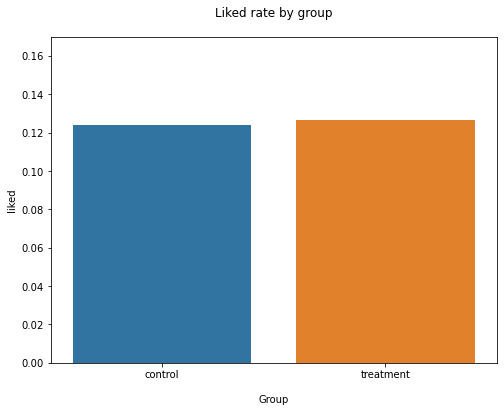

In [19]:
# Plot the like rate by group on a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'], y=ab_test['liked'], ci=False)

plt.ylim(0, 0.17)
plt.title('Liked rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Liked (propotion)', label)


### Testing for Stat Sig

In [29]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups
control_results=ab_test[ab_test['group']=='control']['liked']
treatment_results=ab_test[ab_test['group']=='treatment']['liked']

# Get the number of samples in both groups
n_con=control_results.count()
n_treat= treatment_results.count()

# Sum up the number of successes (likes) in both groups
successes= [control_results.sum(), treatment_results.sum()]
nobs= [n_con, n_treat]

In [32]:
# Find the z statistic and p value for proportions based on normal ztest
zstat, pval= proportions_ztest(successes, nobs=nobs)

# Find the confidence intervals for each test group
(lower_con, lower_treat), (upper_con, upper_treat)= proportion_confint(successes, nobs=nobs, alpha=0.05)



In [33]:
# print z statistic
print(f'z statistic: {zstat: .2f}')

# print p-value
print(f'p-value: {pval: .3f}')

# print ci 95% for control group
print( f'ci 95% for control group: [{lower_con: .3f}, {upper_con: .3f}]')

# print ci 95% for treatment group
print(f'ci 95% for treatment group: [{lower_treat: .3f}, {upper_treat: .3f}]')


z statistic: -0.51
p-value:  0.610
ci 95% for control group: [ 0.116,  0.131]
ci 95% for treatment group: [ 0.119,  0.134]


### Were the results signficant? 

In [ ]:
Yes

### What would you advise the engineering team to do moving forward?

In [ ]:
#